In [1]:
from gensim.models import Doc2Vec
from sklearn import decomposition
import numpy as np  
import sys
import operator
from sklearn import metrics
from sklearn import preprocessing
from sklearn import cross_validation
from adjustText import adjust_text

import heapq
import pandas as pd
import random as rnd
from random import shuffle
import collections
import matplotlib.ticker as ticker

from heapq import nlargest

from twitch import commons

%pylab inline
matplotlib.use('Agg')
import matplotlib
import matplotlib.pyplot as plt

# fig_size = plt.rcParams["figure.figsize"]
# fig_size[0] = 12
# fig_size[1] = 9
# plt.rcParams["figure.figsize"] = fig_size

import matplotlib.pylab as pylab

# params = {'legend.fontsize': 'xx-large',
#           'axes.labelsize': 'xx-large',
#           'axes.titlesize': 'xx-large',
#           'xtick.labelsize': 'xx-large',
#           'ytick.labelsize': 'xx-large'}

# pylab.rcParams.update(params)

Populating the interactive namespace from numpy and matplotlib


//anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
`%matplotlib` prevents importing * from pylab and numpy


In [2]:
df = pd.read_csv('./user_chat_counts.csv.dat', header=None, names=['user', 'total', 'male', 'female'])
df['female_chat_percentage'] = (df.female*100)/df.total

print('all users: ' + str(len(df.index)))

print('users with atleast 100 messages: ' + str(len(df[df.total >= 100].index)))

all_users = df[(df.total >= 100)]
selected_users = df[(df.total >= 100) & ((df.female_chat_percentage == 100) | (df.female_chat_percentage == 0))]
users = selected_users.user.tolist()
female_chat_percentages = selected_users.female_chat_percentage.tolist()

no_of_users = len(users)
print('filtered users: ' + str(no_of_users))

print(df.total.sum())

all users: 1818028
users with atleast 100 messages: 93898
filtered users: 42068
69691577


In [3]:
all_users['male_chat_percentage'] = 100 - all_users.female_chat_percentage

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [4]:
all_users['male_chat_percentage'] = all_users['male_chat_percentage'].astype(int)
all_users['female_chat_percentage'] = all_users['female_chat_percentage'].astype(int)

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


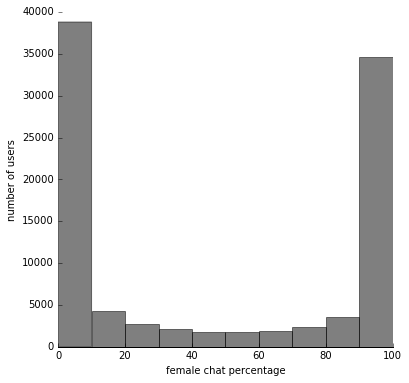

In [5]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 6
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size

# df2 = all_users.groupby(['female_chat_percentage']).count()
# ax = df2.total.plot(kind='bar', color='black')
ax = all_users.female_chat_percentage.plot(kind='hist', color='k', alpha=0.5, bins=10)
ax.set_ylabel('number of users')
ax.set_xlabel('female chat percentage')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
# ax.set_yscale("log")
# ax.set_ylim(ymax=30000)
# for label in ax.xaxis.get_ticklabels()[1:100]:
#     label.set_visible(False)
# for label in ax.xaxis.get_ticklabels()[:100:5]:
#     label.set_visible(True)

In [6]:
user_channel_counts_df = pd.read_csv('./user_channel_counts.csv.dat',
                                     header=None, names=['user', 'channel_count'])
users_with_n_channels = user_channel_counts_df[user_channel_counts_df.channel_count >= 5].user.values.tolist()
len(users_with_n_channels)
df5 = all_users[all_users.user.isin(users_with_n_channels)]

users_with_n_channels = user_channel_counts_df[user_channel_counts_df.channel_count >= 10].user.values.tolist()
len(users_with_n_channels)
df10 = all_users[all_users.user.isin(users_with_n_channels)]

In [7]:
df5[df5.female_chat_percentage==0].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1813 entries, 1853 to 1815081
Data columns (total 6 columns):
user                      1813 non-null object
total                     1813 non-null int64
male                      1813 non-null int64
female                    1813 non-null int64
female_chat_percentage    1813 non-null int64
male_chat_percentage      1813 non-null int64
dtypes: int64(5), object(1)
memory usage: 99.1+ KB


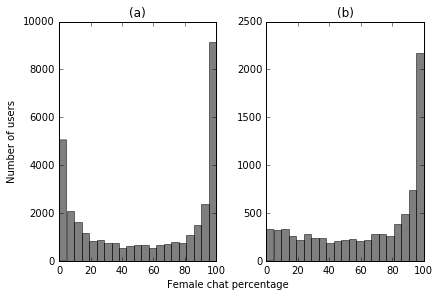

In [8]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 6
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size

fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

df5.female_chat_percentage.plot(kind='hist', color='k', alpha=0.5, bins=21, ax=ax1)
df10.female_chat_percentage.plot(kind='hist', color='k', alpha=0.5, bins=21, ax=ax2)
ax1.set_ylabel('')
ax2.set_ylabel('')

fig.text(0.5, 0.0, 'Female chat percentage', ha='center', va='center')
fig.text(0.0, 0.5, 'Number of users', ha='center', va='center', rotation='vertical')

ax1.set_title('(a)')
ax2.set_title('(b)')
fig.tight_layout()

plt.draw()
plt.savefig('user_chat_distribution.svg', format='svg')

In [9]:
model = Doc2Vec.load('./user_all_chats.d2v')

In [10]:
len(model.index2word)

2750939

In [11]:
non_normalized_feature_vectors = [model.docvecs[x] for x in users]

feature_vectors = preprocessing.normalize(preprocessing.scale(non_normalized_feature_vectors))

In [12]:
print(len(feature_vectors))

42068


### classification model

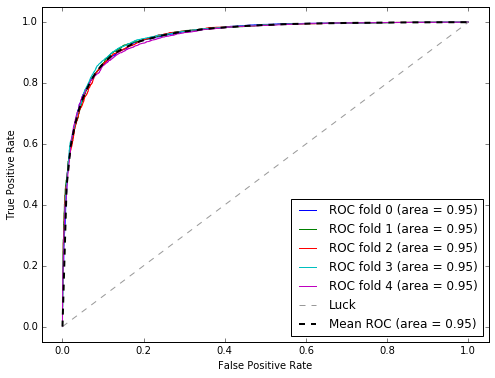

Accuracy: 0.88 (+/- 0.01)


In [13]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 8
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size

y = np.array([0 if female_chat_percentages[i] >= 50 else 1 for i in range(len(feature_vectors))])
(lr, coef, _) = commons.build_lr_classification_model_cv(feature_vectors, y, 5)

### Words which has the highest & lowers probability with trained logistic regression (from frequent 100,000 words)

In [14]:
all_words_dic = commons.read_word_count_file("../../data/word_counts/global_word_counts.csv")
all_words_list = sorted(all_words_dic.items(), key=operator.itemgetter(1), reverse=True)

In [15]:
selected_word_vectors = []
selected_words = []
count = 0
for w in all_words_list:
    if count < 10000:
        try:
            selected_word_vectors.append(model[w[0]])
            selected_words.append(w)
            count += 1
        except:
            continue
    else:
        break
selected_word_vectors = preprocessing.normalize(preprocessing.scale(selected_word_vectors))

In [16]:
word_similarity_dic = {}
for i,w in enumerate(selected_words):
    try:
        word_similarity_dic[w[0]] = lr.predict_proba(selected_word_vectors[i].reshape(1, -1))[0][1]
    except:
        continue

In [17]:
top_female_words = heapq.nlargest(25, word_similarity_dic, key=word_similarity_dic.get)
print(', '.join(top_female_words))

print('')

top_male_words = heapq.nsmallest(25, word_similarity_dic, key=word_similarity_dic.get)
print(', '.join(top_male_words))

ridley, quad, melee, cirno, glitch, unlocked, leaderboards, mechanic, resets, rebirth, ganon, shulk, ryu, dupe, stage, upgrades, engine, speedrunning, hydro, demo, dynasty, bowser, dash, footage, strat

gorgeous, beautiful, makeup, wig, cute, marry, dress, perv, pervert, smile, blonde, cat, snapchat, lovely, eyes, beauty, thirsty, personality, compliment, cosplay, jealous, adorable, hii, instagram, nicole


### clustering

In [18]:
sample_size = 10000

# records_df = df[(df.total >= 100) & ((df.female_chat_percentage == 100) 
#                                   | (df.female_chat_percentage == 0))].sample(sample_size)

records_df = pd.read_csv('./user_chat_clustering_selected_sample.csv.dat')
# records_df.to_csv('./user_chat_clustering_selected_sample.csv.dat', index=False)

records = records_df.values.tolist()

users_sample = [r[0] for r in records]
percentages = [int(r[4]) for r in records]
vectors = [model.docvecs[x] for x in users_sample]

vectors = preprocessing.normalize(preprocessing.scale(vectors))

In [19]:
# all_xy_vectors = commons.reduce_dim(vectors, 'tsne')
# np.save('./user_chat_2d_xy_vectors.npy', all_xy_vectors)

all_xy_vectors = np.load('./user_chat_2d_xy_vectors.npy')

In [20]:
doc_xy_vectors = all_xy_vectors[0:sample_size]

In [21]:
with open('tsne-users.dat', 'w') as fp:
    for item in users_sample:
        fp.write("%s\n" % item)

In [22]:
vectors = [model.docvecs[x] for x in users_sample]

word1_points = []
for i,v in enumerate(vectors):
    if commons.cosine_similarity(model['run'], v) >= 0.416:
        word1_points.append(doc_xy_vectors[i])

print(len(word1_points))

word2_points = []
for i,v in enumerate(vectors):
    if commons.cosine_similarity(model['dance'], v) >= 0.331:
        word2_points.append(doc_xy_vectors[i])

print(len(word2_points))

# word1_points = []
# for i,v in enumerate(vectors):
#     if commons.cosine_similarity(model['great'], v) >= 0.365:
#         word1_points.append(doc_xy_vectors[i])

# print(len(word1_points))

# word2_points = []
# for i,v in enumerate(vectors):
#     if commons.cosine_similarity(model['cute'], v) >= 0.395:
#         word2_points.append(doc_xy_vectors[i])

# print(len(word2_points))

252
252


(-10, 10)

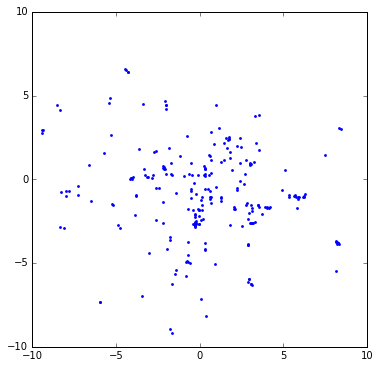

In [23]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 6
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size

plt.scatter([x[0] for x in word2_points], [y[1] for y in word2_points],s=8, c='b', lw=0, label='male')
plt.xlim(xmin=-10, xmax=10)
plt.ylim(ymin=-10, ymax=10)

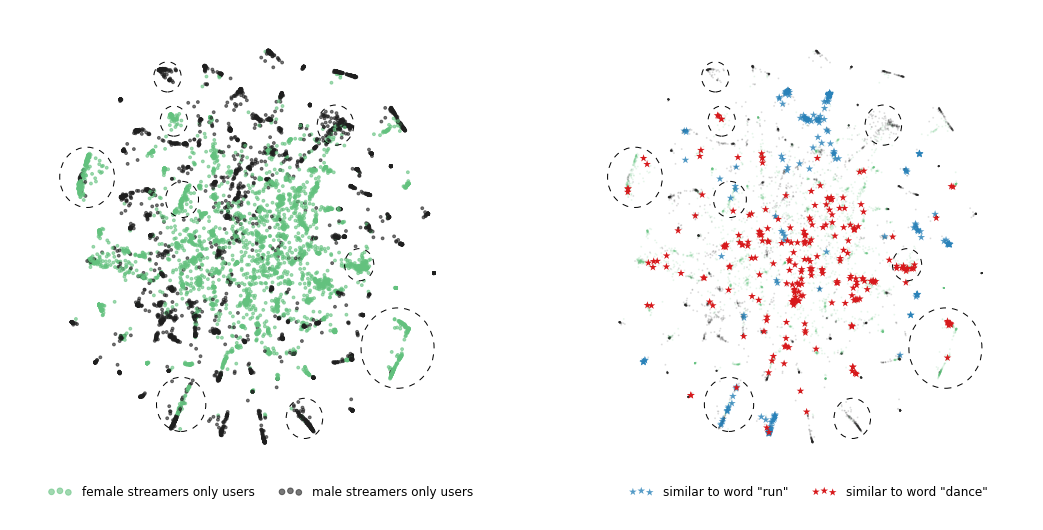

In [24]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 9 * 2
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size

colors = ['#63c17e' if percentages[i] >= 50 else '#1F1F1F' for i in range(0,10000)]

#facecolors='none', edgecolors='#2ca25f'
# plt.scatter([x[0] for i,x in enumerate(doc_xy_vectors) if percentages[i] >= 50],
#             [y[1] for i,y in enumerate(doc_xy_vectors) if percentages[i] >= 50],
#             s=32, color='#63c17e' , lw=1, label='female streamer only users', alpha=0.6)
 
# #facecolors='none', edgecolors='#8856a7'
# plt.scatter([x[0] for i,x in enumerate(doc_xy_vectors) if percentages[i] < 50],
#             [y[1] for i,y in enumerate(doc_xy_vectors) if percentages[i] < 50],
#             s=32, color='#1F1F1F', lw=1, label='male streamer only users', alpha=0.6)
ax1 = plt.subplot(121)

plt.scatter([x[0] for x in doc_xy_vectors],
            [y[1] for y in doc_xy_vectors],
            s=8, color=colors, lw=1, alpha=0.6)

plt.xlim(xmin=-12, xmax=13)
plt.ylim(ymin=-13, ymax=12)

plt.scatter([-50], [-50], s=32, color='#63c17e' , lw=1, label='female streamers only users', alpha=0.6)
plt.scatter([-50], [-50], s=32, color='#1F1F1F', lw=1, label='male streamers only users', alpha=0.6)
  

clusters = collections.OrderedDict([
        ('Dota',(-9, 3.5, 1.5)),
        ('LoL',(4.6, 6.1, 1)),
        ('DarkSouls',(-3.85, -7.8, 1.35)),
        ('SSB',(2.9, -8.5, 1)),
        ('Kaceytron',(5.9, -0.85, 0.8)),
        ('Kitty',(-4.25, 6.3, 0.75)),
        ('Trick2g',(-4.6, 8.5, 0.75)),
        ('Moderation',(-3.8, 2.4, 0.9)),
        ('Spanish',(8, -5, 2)),
])

# selecting users in each cluster
with open('cluster_users.csv.dat', 'w') as fp:
    for index,cluster in enumerate(clusters):
        x,y,r = clusters[cluster]
        cluster_users = []
        for i,(x_doc,y_doc) in enumerate(doc_xy_vectors):
            if (math.pow((x-x_doc), 2) + math.pow((y-y_doc), 2)) <= math.pow(r,2):
                cluster_users.append(users_sample[i])
        fp.write(cluster + "," + ' '.join(cluster_users) + "\n")
        circle = plt.Circle((x,y), radius=r, fill=False, lw=1, color='black', linestyle='--'
                            #,label=cluster +" : " + str(len(cluster_users))
                           )
        plt.gca().add_patch(circle)
        

leg = plt.legend(loc='lower center', ncol=2)
plt.axis('off')
leg.draw_frame(False)
#--------------------------------------------------
ax2 = plt.subplot(122)
plt.scatter([x[0] for x in doc_xy_vectors],
            [y[1] for y in doc_xy_vectors],
            s=1, color=colors, lw=1, alpha=0.1)

plt.scatter([x[0] for x in word1_points], [y[1] for y in word1_points], s=64, c='#2b83ba', lw=0,
            label='similar to word \"run\"', marker='*', edgecolors='none', alpha=0.8)

plt.scatter([x[0] for x in word2_points], [y[1] for y in word2_points], s=64, c='#d7191c', lw=0,
            label='similar to word \"dance\"', marker='*', edgecolors='none')

plt.xlim(xmin=-12, xmax=13)
plt.ylim(ymin=-13, ymax=12)

# selecting users in each cluster
with open('cluster_users.csv.dat', 'w') as fp:
    for index,cluster in enumerate(clusters):
        x,y,r = clusters[cluster]
        cluster_users = []
        for i,(x_doc,y_doc) in enumerate(doc_xy_vectors):
            if (math.pow((x-x_doc), 2) + math.pow((y-y_doc), 2)) <= math.pow(r,2):
                cluster_users.append(users_sample[i])
        fp.write(cluster + "," + ' '.join(cluster_users) + "\n")
        circle = plt.Circle((x,y), radius=r, fill=False, lw=1, color='black', linestyle='--'
                            #,label=cluster +" : " + str(len(cluster_users))
                           )
        plt.gca().add_patch(circle)
        
leg = plt.legend(loc='lower center', ncol=2)
plt.axis('off')
leg.draw_frame(False)
plt.draw()
plt.savefig('user_clusters_word_sims.eps', format='eps')
# savefig('user_clusters.png')

In [25]:
len([x[0] for i,x in enumerate(doc_xy_vectors) if percentages[i] >= 50],)

4802

In [26]:
len([x for x in percentages if x < 50])

5198

### similarity between word vectors and document vectors

In [27]:
def plot_word_2_doc_similarity_plot(word1, word2):
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 6
    fig_size[1] = 4
    plt.rcParams["figure.figsize"] = fig_size

    word_vec_1 = model[word1]
    word_vec_2 = model[word2]
    
    similarity_values = []
    sample_size = 2500
    records = rnd.sample(df[(df.total >= 100)].values.tolist(), sample_size)
    users_sample = [r[0] for r in records]
    percentages = [int(r[4]) for r in records]
    doc_vectors = [model.docvecs[x] for x in users_sample]
    
    for doc_vec in doc_vectors:
        similarity_values.append((commons.cosine_similarity(word_vec_1, doc_vec), commons.cosine_similarity(word_vec_2,
                                                                                                            doc_vec)))
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    cm = plt.cm.get_cmap('RdYlBu_r')
    sc = plt.scatter([x[0] for x in similarity_values],[y[1] for y in similarity_values], s=8, c=percentages,
                     lw=0, cmap=cm)
    plt.xlabel(word1)
    plt.ylabel(word2)
    plt.plot([0, 1], [0, 1], 'b--', transform=ax.transAxes)

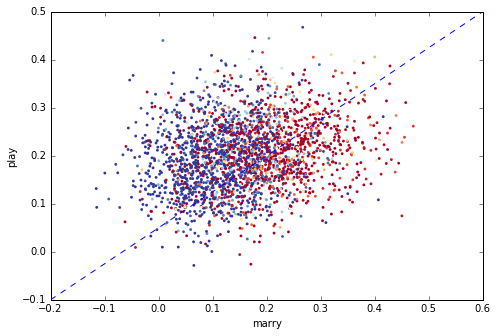

In [28]:
plot_word_2_doc_similarity_plot('marry', 'play')

### document vector projections in directions

In [29]:
def docvec_projections_plot(words, indices):
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 16
    fig_size[1] = 6
    plt.rcParams["figure.figsize"] = fig_size
    sample_size = 25000
    records = rnd.sample(df[(df.total >= 100) & ((df.female_chat_percentage == 100) 
                                                 | (df.female_chat_percentage == 0))].values.tolist(), sample_size)
    users_sample = [r[0] for r in records]
    percentages = [int(r[4]) for r in records]
    total_chats = [int(r[1]) for r in records]
    doc_vectors = [model.docvecs[x] for x in users_sample]
    number_of_subplots = len(words)
    fig = plt.figure()
    
    values = []
    for image_no,(word1, word2) in enumerate(words):
        word1_word2_vec = model[word1] - model[word2]
        similarity_values_f = []
        similarity_values_m = []
        for i,vec in enumerate(doc_vectors):
            if percentages[i] > 50:
                similarity_values_f.append(commons.cosine_similarity(word1_word2_vec, vec))
            else:
                similarity_values_m.append(commons.cosine_similarity(word1_word2_vec, vec))
    
        weights = np.ones_like(similarity_values_f)/float(len(similarity_values_f))
        ax = plt.subplot(indices[image_no])
        (n, bins, patches) = ax.hist(similarity_values_f, bins=50, weights=weights, facecolor='#63c17e', alpha=0.5, linewidth=0)
        weights = np.ones_like(similarity_values_m)/float(len(similarity_values_m))
        ax.hist(similarity_values_m, bins=bins, weights=weights, facecolor='#1F1F1F', alpha=0.5, linewidth=0)
#         plt.xlabel(word2 + " <> " + word1)
#         plt.ylabel('probability')
        plt.xlim(xmin=-0.5,xmax=0.5)
        plt.ylim(ymin=0)
        plt.axvline(0, color='k', linestyle='dashed', linewidth=1)
        
        if (image_no != 0) and (image_no !=4):
            ax.get_yaxis().set_visible(False)
        if image_no < 4:
            ax.get_xaxis().set_visible(False)
        
        values.append((similarity_values_f, similarity_values_m))
    
    l1 = plt.bar([0], [0], color='#63c17e', alpha=0.6)
    l2 = plt.bar([0], [0], color='#1F1F1F', alpha=0.6)
    fig.legend((l1, l2),  ('female streamer only users', 'male streamer only users'), 'lower center',
               bbox_to_anchor=(0.5, 1),
               fancybox=True)
    fig.text(0.5, 0.0, 'Cosine Similarity', ha='center')
    fig.text(0.0, 0.5, 'Probability', va='center', rotation='vertical')
    fig.tight_layout()
#     plt.show()
    
    plt.draw()
    plt.savefig('cosine_similarity_skew.svg', format='svg', dpi=300)
    
    return values

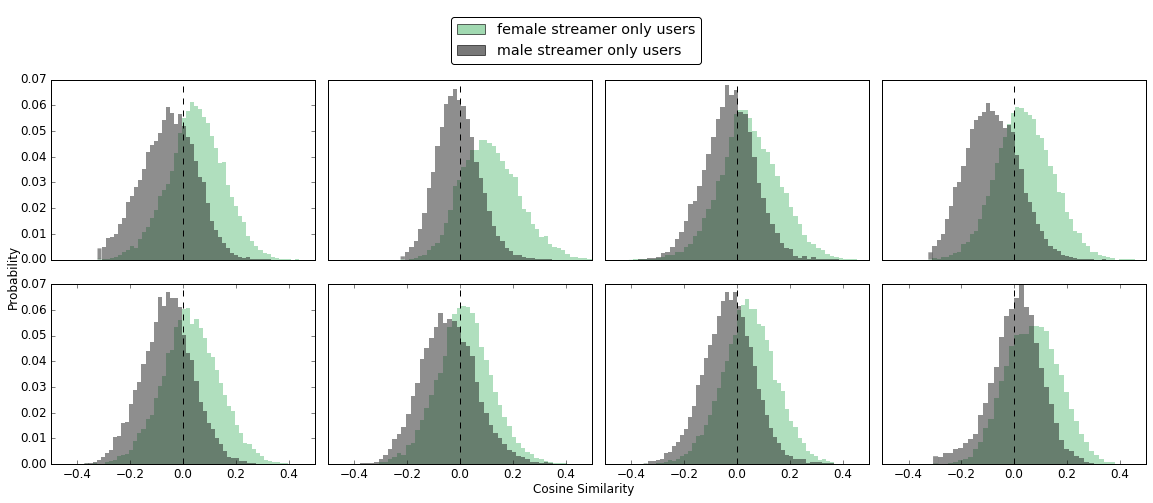

In [46]:
pylab.rcParams.update({'font.size': 12})

words = [('dance','run'), ('gorgeous','great'),('snapchat', 'steam'), ('cute', 'super'), ('marry', 'play'), ('song', 'game'),
         ('cosplay','gameplay'), ('boyfriend','champion')]
values = docvec_projections_plot(words, [241, 242, 243, 244, 245, 246, 247, 248])

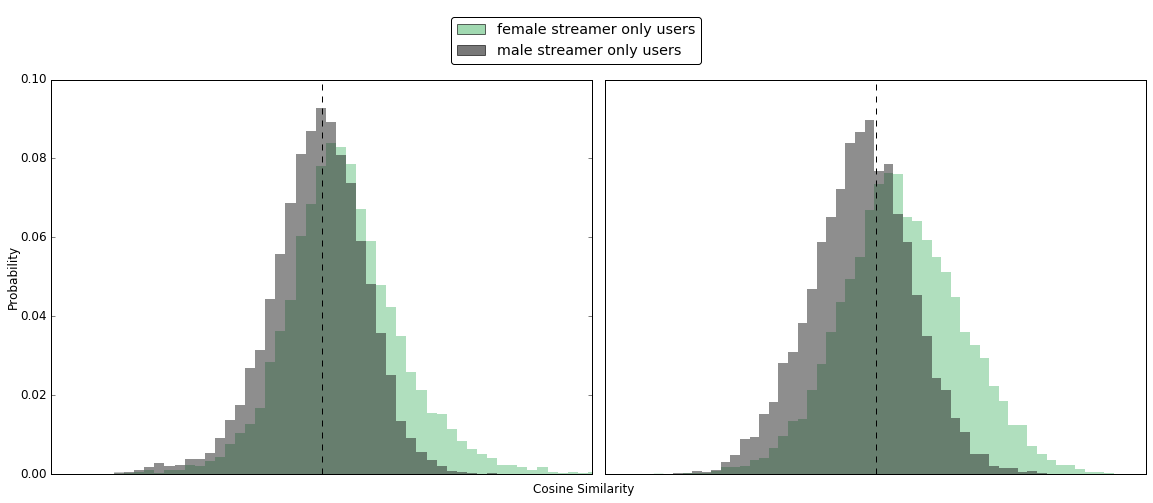

In [31]:
_ = docvec_projections_plot([('boobs','points'),('snapchat','steam')], [121, 122])

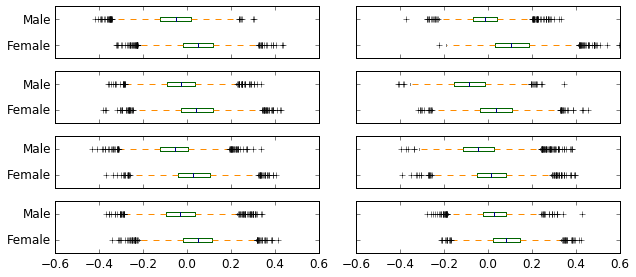

In [32]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 9
fig_size[1] = 1*4
plt.rcParams["figure.figsize"] = fig_size

color = dict(boxes='DarkGreen', whiskers='DarkOrange', medians='DarkBlue', caps='Gray')
fig = plt.figure()
positions = [421, 422, 423, 424, 425, 426, 427, 428]
for i,(x,y) in enumerate(values):
    ax = fig.add_subplot(positions[i])
    box_plot_df = pd.DataFrame({'Female': x[0:4800], 'Male': y[0:4800]})
    box_plot_df.plot.box(color=color, vert=False, sym='r+', fontsize=12, ax=ax)
    ax.set_xlim(xmin=-0.6, xmax=0.6)
    if i < 6:
        plt.setp(ax.get_xticklabels(), visible=False)
    if (i+1)%2 == 0:
        plt.setp(ax.get_yticklabels(), visible=False)
        
fig.tight_layout()

### finding words for clusters

In [33]:
cluster_users = {line.split(',')[0] : line.split(',')[1].strip().split(' ') for line in 
                 open('./cluster_users.csv.dat','r')}

In [34]:
for cluster in cluster_users:
    if cluster=='X':
        cluster_users_list = cluster_users[cluster]
        n = len(cluster_users_list)
        words = collections.Counter()
        for w in [word[0] for word in selected_words]:
            count = 0
            for i,v in enumerate(vectors):
                if (users_sample[i] in cluster_users_list) and (commons.cosine_similarity(model[w], v) >= 0.4):
                    count += 1
            if count >= (n * 0.8):
                words[w] = count

        print(cluster + " : " + str(words.most_common(10)))
        print('')

# Infering vectors for channels

In [35]:
female_channels = [line.strip().split(',')[0] for line in open('../female_channels.csv', 'r')]
male_channels = [line.strip().split(',')[0] for line in open('../male_channels.csv', 'r')]

In [36]:
channel_chat_log = []
for female in female_channels:
    message = []
    with open('../../data/channel_chat_logs/cleaned/' + female + "_chat_log.csv") as f:
        for line in f:
            splits = line.split(',')
            message.append(splits[3])
    channel_chat_log.append(' '.join(message))

In [37]:
for male in male_channels:
    message = []
    with open('../../data/channel_chat_logs/cleaned/' + male + "_chat_log.csv") as f:
        for line in f:
            splits = line.split(',')
            message.append(splits[3])
    channel_chat_log.append(' '.join(message))

In [38]:
channel_vectors = []
n = 400
for i in range(n):
    channel_vectors.append(model.infer_vector(channel_chat_log[i].split(), steps=1))

In [39]:
channel_points = []
for i in range(n):
    channel_vector = channel_vectors[i]
    max_cosine_sim = -1
    cordinates = [0,0]
    for i,v in enumerate(vectors):
        temp_cosine_similarity = commons.cosine_similarity(channel_vector, v)
        if  temp_cosine_similarity >= max_cosine_sim:
            cordinates = doc_xy_vectors[i]
            max_cosine_sim = temp_cosine_similarity
    
    channel_points.append(cordinates)
    
print(len(channel_points))

400


In [40]:
# words = []
words = ['boobs', 'tits', 'cute', 'marry', 'beautiful', 'points', 'winner', 'battle', 'rank', 'star']
word_points = []
for i in range(len(words)):
    word_vector = model[words[i]]
    max_cosine_sim = -1
    cordinates = [0,0]
    for i,v in enumerate(vectors):
        temp_cosine_similarity = commons.cosine_similarity(word_vector, v)
        if  temp_cosine_similarity >= max_cosine_sim:
            cordinates = doc_xy_vectors[i]
            max_cosine_sim = temp_cosine_similarity
    
    word_points.append(cordinates)
    
print(len(word_points))

10


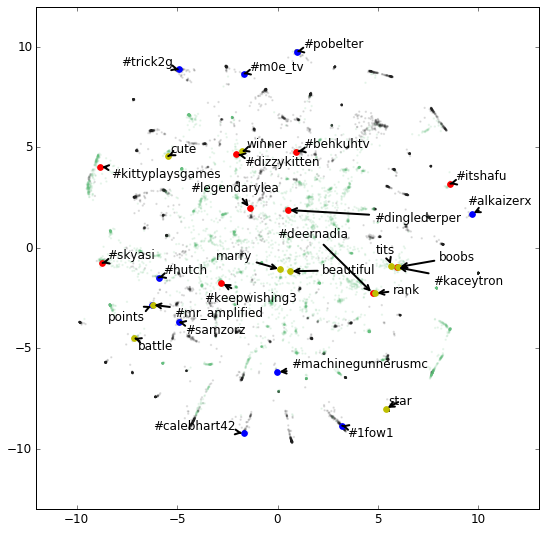

In [41]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 9
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size

temp_n = 10

plt.xlim(xmin=-12, xmax=13)
plt.ylim(ymin=-13, ymax=12)
plt.scatter([x[0] for x in doc_xy_vectors], [y[1] for y in doc_xy_vectors], s=2, color=colors, lw=1, alpha=0.1)

text = ['#' + x for x in female_channels[0:temp_n] + male_channels[0:temp_n]] + words
eucs = [x for (x,y) in channel_points[0:temp_n] + channel_points[200:200+temp_n]] + [x for (x,y) in word_points]
covers = [y for (x,y) in channel_points[0:temp_n] + channel_points[200:200+temp_n]] + [y for (x,y) in word_points]

p1 = plt.scatter(eucs[0:temp_n],covers[0:temp_n], color='r', s=32)
p2 = plt.scatter(eucs[temp_n:temp_n*2],covers[temp_n:temp_n*2], color='b', s=32)
p3 = plt.scatter(eucs[temp_n*2:temp_n*2+len(words)],covers[temp_n*2:temp_n*2+len(words)], color='y', s=32)

texts = []
for x, y, s in zip(eucs, covers, text):
    texts.append(plt.text(x, y, s, size=12))
adjust_text(texts, arrowprops=dict(arrowstyle="->", color='k', lw=2))


plt.show()

In [42]:
temp = commons.reduce_dim(channel_vectors + vectors, 'tsne')

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 10400
[t-SNE] Computed conditional probabilities for sample 2000 / 10400
[t-SNE] Computed conditional probabilities for sample 3000 / 10400
[t-SNE] Computed conditional probabilities for sample 4000 / 10400
[t-SNE] Computed conditional probabilities for sample 5000 / 10400
[t-SNE] Computed conditional probabilities for sample 6000 / 10400
[t-SNE] Computed conditional probabilities for sample 7000 / 10400
[t-SNE] Computed conditional probabilities for sample 8000 / 10400
[t-SNE] Computed conditional probabilities for sample 9000 / 10400
[t-SNE] Computed conditional probabilities for sample 10000 / 10400
[t-SNE] Computed conditional probabilities for sample 10400 / 10400
[t-SNE] Mean sigma: 1.105110
[t-SNE] Iteration 25: error = 1.1549095, gradient norm = 0.0062691
[t-SNE] Iteration 50: error = 1.1711900, gradient norm = 64.3594666
[t-SNE] Iterati

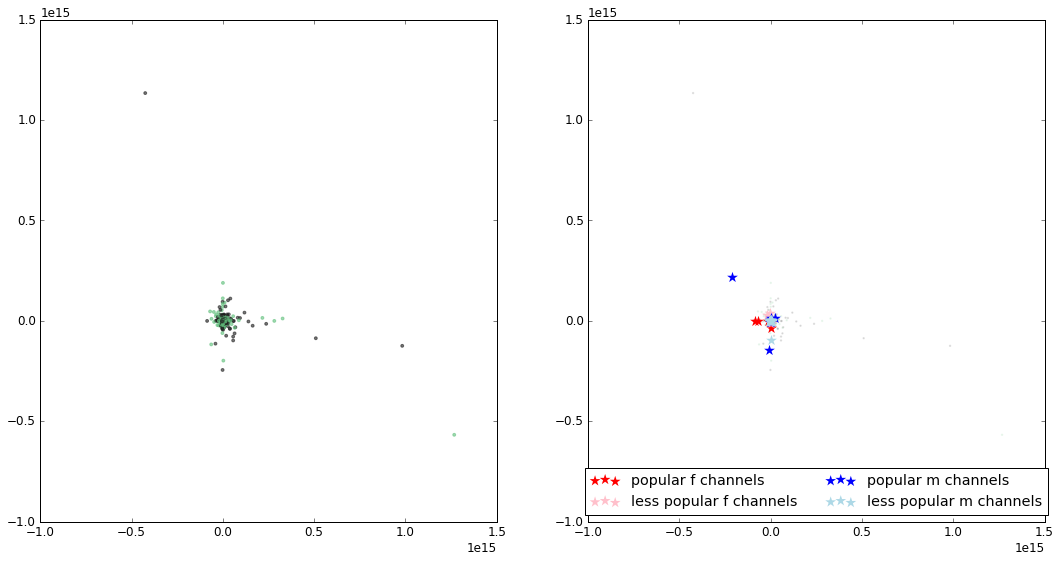

In [43]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 9 * 2
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size

channel_xy_vectors = temp[0:400]
doc_xy_vectors = temp[400:10400]

ax1 = plt.subplot(121)

plt.scatter([x[0] for x in doc_xy_vectors],
            [y[1] for y in doc_xy_vectors],
            s=8, color=colors, lw=1, alpha=0.6)

ax1 = plt.subplot(122)

plt.scatter([x[0] for x in doc_xy_vectors],
            [y[1] for y in doc_xy_vectors],
            s=2, color=colors, lw=1, alpha=0.1)

plt.scatter([x[0] for x in channel_xy_vectors[0:100]],
            [y[1] for y in channel_xy_vectors[0:100]], s=128, color='r', marker='*', lw=0, alpha=1,
            label='popular f channels')

plt.scatter([x[0] for x in channel_xy_vectors[100:200]],
            [y[1] for y in channel_xy_vectors[100:200]], s=128, color='pink', marker='*', lw=0, alpha=1,
            label='less popular f channels')

plt.scatter([x[0] for x in channel_xy_vectors[200:300]],
            [y[1] for y in channel_xy_vectors[200:300]], s=128, color='blue', marker='*', lw=0, alpha=1,
            label='popular m channels')

plt.scatter([x[0] for x in channel_xy_vectors[300:400]],
            [y[1] for y in channel_xy_vectors[300:400]], s=128, color='#ADD8E6', marker='*', lw=0, alpha=1,
            label='less popular m channels')

leg = plt.legend(loc='lower center', ncol=2)

In [44]:
len(channel_xy_vectors)

400

In [45]:
len(vectors)

10000